<a href="https://colab.research.google.com/github/dbarrau/analisis_texto_borrador_constitucion_chile/blob/main/cos_similitud_ch_y_vecinos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de textos constitucionales en Sudamérica, con énfasis en Chile

## 1. Resumen

Dado el proceso constituyente que se dio en Chile entre el 2020 y el reciente plebiscito de salida el 4 de Septiembre, utilicé este impulso para para demostrar cómo el uso de algunas técnicas analíticas que son aplicables en textos constitucionales, que pueden cuantificar cuán símiles son diferentes constituciones bajo la extracción de características mediante el preprocesamiento del texto, seguido por la aplicación de dos algoritmos de vectorización de texto:

<br>

* **Vectorización de conteo:** Se obtiene el conteo de palabras en un documento.
* **Vectorización Tf-Idf:** (del inglés "Term frequency - Inverse document frequency") Similar a la vectorización de conteo, pero además otorga mayor peso a palabras que son propias del documento al cual pertenecen, y que son menos frecuentes en los demás documentos.

<br>

seguido por la medición de cuán símiles son los vectores resultantes mediante la similitud del coseno.

Mediante este procedimiento analizaron los textos constitucionales de Chile (actual y borrador) y países vecinos más el documento de Venezuela. Los resultados arrojaron que la mayor similitud respecto a la distribución de palabras, se dio entre el borrador constitucional de Chile y la constitución actual de Venezuela, con una similitud de 0.78 (medible entre 0 y 1). En cuanto al análisis de los vectores tf-idf, la mayor similitud se dio entre la constitución de Perú y el borrador de la constitución de Chile, con un valor de 0.71. Respecto a la constitución vigente, la mayor similitud en cuanto a distribución de frecuencia de palabras fue la constitución vigente de Perú. La menor similitud fue observada entre el borrador constitucional y la constitución vigente de Chile.

<br>

> **Nota -** La vectorización Tf-Idf considera tanto frecuencia como relevancia de la palabra, y técnicamente otorga un mejor nivel de análisis. Sin embargo por curiosidad optamos también por la vectorización de conteo.


## 2. Objetivos y alcance

<br>



### 2.1. Objetivos

* Medir el grado de similitud entre el borrador y constitución vigentede la República de Chile, sus vecinos y la República Bolivariana de Venezuela.

* Demostrar cómo mediante técnicas de análisis de texto, se puede extraer información relevante para la toma de decisiones.  

<br>



### 2.2. Alcance

Este trabajo se enfoca en el análisis del borrador y constitución vigente de la República de Chile entre las constituciones mencionadas en los objetivos.

## 3. Métodos y procedimientos

Esta sección contiene los métodos analíticos, requerimientos y pasos para llevar a cabo el análisis. Incluye:

* Importación de librerías necesarias, definición de funciones
* Manejo de *stopwords*
* Importación y preprocesamiento de la data
* Vectorización 
* Medición de similtud

### 3.1 Importación de librerías necesarias, definición de funciones y manejo de stopwords

Esta sección llama los requerimientos de paquetes, herramientas y funciones que vamos a utilizar en el análisis:

* **Descarga de requerimientos para librería de procesamiento de texto:** 
  * `nltk.download("punkt")`
  * `nltk.download("stopwords")`

* **Definición de clase Stemmer:** Esta clase es llamada en el argumento `tokenizer` dentro de ambos vectorizadores: `CountVectorizer()` y `TfidfVectorizer()`

* **Preprocesamiento de data:** Este proceso incluye:
  * Cargar archivo de texto
  * Aplicación de minúsculas a todas las palabras
  * Exclusión de palabras de menos de tres caracteres
  * Exclusión de *stopwords*
  * Exclusión de secuencias no alfabéticas


In [ ]:
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize          
from nltk.stem import SnowballStemmer 

# DOWNLOAD NLTK REQUIREMENTS

# Required by nltk stemmer

nltk.download('punkt')

# Required for filtering stopwords
nltk.download("stopwords")

# Function for preprocessing .txt constitution file 
def preprocess_constitution_txt(path, stopwords):

  """
    Preprocesses a filename from a path by splitting the words, lowercasing and
    alphabetic sequences longer than 3 characters, and filtering stopwords out.
    returns a single preprocessed string with the corpus

    Args:

      path (str):       path to file

      stopwords (list): list of stopwords obtained importing nltk 
                        and nltk.download("stopwords),
                        and setting stopwords = stopwords.words('spanish')
  """   
  # Open file
  f = open(path)

  # Obtain the corpus in one single string
  corpus = f.readlines()
  corpus = "".join([line for line in corpus])

  # Split string into words
  corpus_split = corpus.split(" ")

  # Filter alphabetic sequences and lowercase them
  alpha_lower = [word.lower() for word in corpus_split if word.isalpha()]

  # Remove stopwords and return joined corpus, applicable in CountVectorizer 
  # and TfidfVectorizer() from sklearn.
  
  alpha_nostopwords = [word for word in alpha_lower if not word in stopwords and len(word) > 3]
  return " ".join(alpha_nostopwords)


# Create dataframe with output from CountVectorizer()
def create_dataframe(matrix, tokens):

  doc_names = [f"doc_{i+1}" for i, _ in enumerate(matrix)]
  df = pd.DataFrame(data=matrix, index=doc_names, columns=tokens)
  df = df.transpose()
  return(df)


columns = ["borrador_ch",
         "const_bo",
         "const_pe",
         "const_ar",
         "const_ve",
         "const_ch_actual"]

sns.color_palette("viridis", as_cmap=True);


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 3.2 Manejo de stopwords

En este paso definimos nuestras "stopwords" en español. En este paso queremos eliminar palabras que no aportan mucha información en general. Mediante este paso logramos una mejor filtración de la data y por ende, un mejor análisis. En este caso, se agregaron como *stopwords* las palabras "artículo", "inciso", "letra", "véase"

In [ ]:
# Stopwords management
stopwords = stopwords.words('spanish')

stopwords_append = ["artículo",
                    "inciso",
                    "letra",
                    "véase"]

for stopword in stopwords_append:

  stopwords.append(stopword)


### 3.3 Importación de la data

Aplicando la función `preprocess_constitution_txt()` cargamos los archivos en una secuencia que continee el texto preprocesado para ser analizado

>**Nota -** A lo largo del documento, se diferencia el texto borrador constitucional de la República de Chile con el texto vigente, con énfasis en la palabra vigente. Por esto, quisiera mencionar que todos los textos constitucionales son hoy vigentes. 

**Textos utilizados:**

* Borrador Constitución de la República de Chile, Mayo, 2022.
* Constitución de la República de Bolivia, Febrero, 2009.
* Constitución de la República del Perú, Julio, 2022.
* Constitución de la República de Argentina, Enero, 1995.
* Constitución de la República Bolivariana de Venezuela, Diciembre, 1999.
* Constitucíón de la República de Chile, Octubre, 2010.

In [ ]:
path = "/content/drive/MyDrive/"
corpus_ch_borrador = preprocess_constitution_txt(path+"borrador_ch.txt", stopwords)
corpus_bo = preprocess_constitution_txt(path+"const_bolivia.txt", stopwords)
corpus_pe = preprocess_constitution_txt(path+"const_peru.txt", stopwords)
corpus_ar = preprocess_constitution_txt(path+"const_argentina.txt", stopwords)
corpus_ve = preprocess_constitution_txt(path+"const_venezuela.txt", stopwords)
corpus_ch = preprocess_constitution_txt(path+"const_chile_vig.txt", stopwords)

Para aplicar ambas vectorizaciones a los documentos, necesitamos el conjunto de documentos en una lista:

In [ ]:
data = [corpus_ch_borrador, 
        corpus_bo, 
        corpus_pe, 
        corpus_ar, 
        corpus_ve, 
        corpus_ch]

### 3.4 Métodos de vectorización

Se llevaron a cabo dos diferentes métodos de vectorización a los textos preprocesados:

* `CountVectorizer()` o en español, vectorizador por conteo. 

* `TfidfVectorizer()` o "Term frequency - inverse document frequency".

Ambos métodos de vectorización involucran dividir los textos en palabras o *tokens*, las cuales son posteriormente procesadas por el algoritmo *Stemmer*, en la sección 3.4.

#### 3.4.1 Definición del `Stemmer()`

*Stemmer* es el algoritmo `SnowballStemmer()` extrae la raíz de las palabras. Así, se pueden agrupar las raíces y podemos extraer resultados más consistentes. En adelante nos referimos a las raíces de obtenidos como **secuencias** o **términos**.


In [ ]:
# Define stemmer for CountVectorizer() and TfidfVectorizer()
class Stemmer(object):
    def __init__(self):
        self.wnl = SnowballStemmer("spanish")
    def __call__(self, articles):
        return [self.wnl.stem(t) for t in word_tokenize(articles)]

#### 3.4.2 Vectorización por conteo (`CountVectorizer()`)

<br>

Inicializamos, entrenamos y transformamos los textos constitucionales preprocesados. En principio, lo que hace este algoritmo es dividir el texto preprocesado en palabras. Además se aplica el algoritmo definido, *Stemmer* que definimos en  

<br>

In [ ]:
# Initialize, fit and transform CountVectorizer
count_vectorizer = CountVectorizer(
    tokenizer=Stemmer(),
    min_df=1)

count_vector_matrix = count_vectorizer.fit_transform(data)

# Prepare count vectors for visualization

count_tokens = count_vectorizer.get_feature_names_out()
count_vectors_df = create_dataframe(count_vector_matrix.toarray(), count_tokens)
count_vectors_df.columns = columns

#### 3.4.3 Vectorización Tf-Idf (`TfidfVectorizer()`)

Del inglés "Term frequency - Inverse document frequency", otorga un puntaje que mide, además de la frecuencia de palabras, la relevancia que ésta tiene. 

**Obtención de $T_f$ :**

La frecuencia de un término en un documento se obtiene mediante la siguiente ecuación:

<br>

$$ T_{f}(t,d) = \frac{f_{t,d}}{\sum_{t^{'}\in d}f_{t^{'},d}} $$

<br>

donde $f_{t,d}$ es el conteo de un término en un documento dado, o el número de veces que $t$ ocurre en el documento $d$ al cual pertenece. El denominador es solamente el conteo total de términos en ese documento.

<br>

**Obtención de $Idf$ :**

El puntaje $Idf$ mide cuanta información la palabra provee, en función de si ésta es muy ocurrente o poco ocurrente en los demás documentos. Corresponde al logaritmo de la frecuencia **inversa** de un término en todos los documentos, y se obtiene de la siguiente manera:

<br>

$$idf(t, D) = log\frac{N}{|\{d \in D : t \in D\}|}$$

<br>

con $N$ siendo el número total de documentos $d$, que pertenecen a una lista de documentos $D$. El denominador es el número total de documentos en el cual el término está presente, y será válido siempre y cuando éste sea distinto de cero. 


**Combinando ámbos**

El puntaje $T_f-Idf$ multiplicando ámbos:

<br>

$$tfidf(t,d,D) = tf(t,d) \cdot idf(t,D)$$



In [ ]:
# Initialize TfidfVectorizer(), fit and transform the data 
tfidf = TfidfVectorizer(tokenizer=Stemmer())
tfidf_vectors = tfidf.fit_transform(data)
tfidf_vectors = tfidf_vectors.toarray()

# Prepare data for visualization
tfidf_tokens = tfidf.get_feature_names_out()
tfidf_vectors_df = create_dataframe(tfidf_vectors, tfidf_tokens)
tfidf_vectors_df.columns = columns 

#### Obtención de similitud del coseno

Éste es un método analítico que mide la similitud entre dos vectores. Podemos calcularlo con la siguiente fórmula:

<br>

$$ K(X,Y) = \frac{X \cdot Y}{||X||*||Y||} $$

<br>

donde $K$ es la similitud del coseno entre los vectores $X$,$Y$. La operación es el producto punto entre ambos vectores, dividido por el producto cruz de la magnitud de ambos vectores.

En nuestro análisis se tomó cada vector generado y se calculó una matríz que contiene las similitudes de cada documento entre sus pares.

In [ ]:

# Compute cosine similarity matrix for vectors
cosine_similarity_matrix = cosine_similarity(count_vector_matrix)
cosine_similarity_tfidf = cosine_similarity(tfidf_vectors)

# Create dataframe of cosine similarities
countvec_cos_df = create_dataframe(cosine_similarity_matrix,columns)
tfidf_cos_df = create_dataframe(cosine_similarity_tfidf,columns)

# Change column names
countvec_cos_df.columns = columns
tfidf_cos_df.columns = columns

In [ ]:
# Settings for visualization
figsize = (20,5)
barwidth = 0.7
colors = plt.cm.Paired(np.arange(len(count_vectors_df)))

## 4. Resultados

La sección de resultados comienza mostrando los histogramas que nos muestran las distribuciones de términos o secuencias tanto del borrador constitucional como de la constitución vigente de la República de Chile respecto a los demás textos, mostrando finalmente la similitud entre textos. A continuación, se muestra una pauta de los resultados.

* Conteo de palabras preprocesadas en ambos textos (sin Stemmer)
* Histogramas de frecuencias de términos:
  * Ordenado por frecuencia en borrador constitucional
  * Ordenado por frecuencia en constitución vigente
  * Análisis exclusivo entre borrador y constitución vigente

* Histogramas de puntajes tf-idf 
  * Ordenado por puntaje en borrador constitucional
  * Ordenaod puntaje en constitución vigente
  * Análisis exclusivo entre borrador y constitución vigente

* Similitudes entre textos constitucionales
  * Frecuencias de términos
  * Puntajes tf-idf

Todos los análisis de histogramas consideraron solo las 30 palabras más utilizadas. Junto con los histogramas, se provee una tabla con los cinco términos con sus puntajes repectivos más altos. 

#### 4.1.1 Conteo de palabras en textos preprocesados

A continuación, obtenemos el conteo total de palabras 

In [ ]:
print(f"""
Conteo de palabras en texto borrador, República de Chile: {len(corpus_ch_borrador.split())}
Conteo de palabras en texto, República de Bolivia: {len(corpus_bo.split())}
Conteo de palabras en texto, República del Perú: {len(corpus_pe.split())}
Conteo de palabras en texto, República Federal de Argentina: {len(corpus_ar.split())}
Conteo de palabras en texto, República Bolivariana de Venezuela: {len(corpus_ve.split())}
Conteo de palabras en texto, República de Chile: {len(corpus_ch.split())}

""")




Conteo de palabras en texto borrador, República de Chile: 16733
Conteo de palabras en texto, República de Bolivia: 14189
Conteo de palabras en texto, República del Perú: 7871
Conteo de palabras en texto, República Federal de Argentina: 4859
Conteo de palabras en texto, República Bolivariana de Venezuela: 13037
Conteo de palabras en texto, República de Chile: 12708




El tamaño total del vocabulario obtenido por la vectorización de conteo se muestra a continuación. Como el proceso de vectorización contiene la misma cantidad de tokens, dado que se aplicó el mismo proceso de tokenización, mediante el Stemmer, tenemos a continuación el tamaño del vocabulario con todas las secuencias:

In [ ]:
print(f"Tamaño de vocabulario luego de la vectorización de conteo: {len(count_tokens)}")
print(f"Tamaño de vocabulario luego de la vectorización de tfidf: {len(tfidf_tokens)}")

Tamaño de vocabulario luego de la vectorización de conteo: 3433
Tamaño de vocabulario luego de la vectorización de tfidf: 3433


### 4.1. Histogramas de conteo de términos

A continuación, podemos visualizar los resultados en histogramas que muestran como el conteo de secuencias se distribuye en el texto constitucional respecto a los otros textos. Los datos fueron reordenados de manera descendente.

#### 4.1.1.Borrador constitucional, República de Chile

<br>

El primer histograma, "Conteo de secuencias, reordenadas respecto al texto borrador constitucional de la República de Chile", muestra la distribución de secuencias más utilizadas. Se observa una distribución heterogénea de palabras entre textos constitucionales. Podemos observar que dentro de la muestra se observa a primera vista, que el texto borrador constitucional contiene más palabras que sus pares, como se observa también en la sección 4.1.1. 


Además de los peaks de secuencias propias del texto borrador, se observan otros peaks, mayores a los conteos del texto borrador, como "president" tanto en los textos de Venezuela y Perú, "public" más presente en el texto peruano y otros.


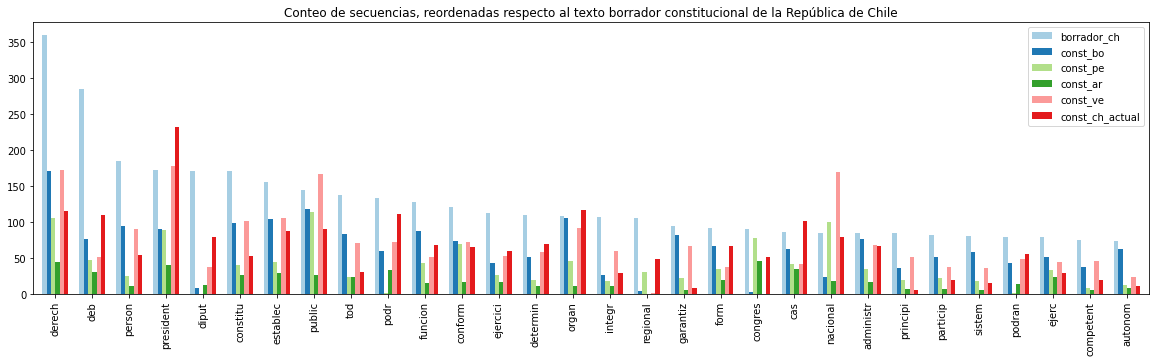

In [ ]:
plot_df_draft = count_vectors_df.sort_values(by="borrador_ch",ascending=False).head(30)
plot_df_draft.plot(kind="bar", figsize=figsize, width=barwidth, color=colors);
plt.title("Conteo de secuencias, reordenadas respecto al texto borrador constitucional de la República de Chile");

In [ ]:
plot_df_draft[["borrador_ch"]].rename(columns={"borrador_ch":"Count"}).head()

,Count
derech,359
deb,284
person,185
president,172
diput,171


#### 4.1.2. Constitución vigente, República de Chile

Análogo a lo realizado con el texto borrador, fue realizado con la constitución vigente. Se observan que la distribución del conteo se se acerca más a sus pares  (ver sección 4.1.1). La secuencia "constitucional" fue ampliamente más utilizada en el texto vigente respecto a los demás, al igual que "reform". Esto da cuenta de todas las reformas constitucionales que han habido desde sus inicios. Adicionalmente se observan peaks de los demás textos. El que tiende a resaltar más por su conteo de secuencias, es nuevamente el texto borrador.


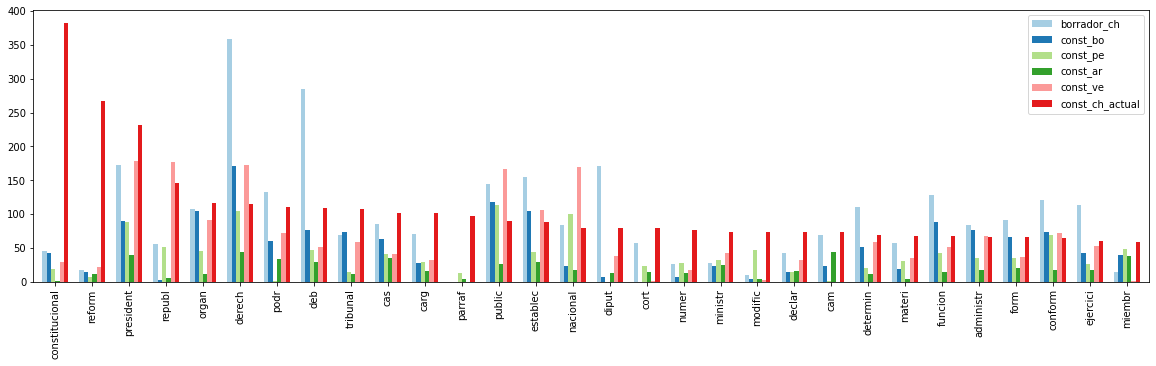

In [ ]:
plot_df_actual = count_vectors_df.sort_values(by="const_ch_actual",ascending=False).head(30)
plot_df_actual.plot(kind="bar", figsize=figsize, width=barwidth, color=colors);

Las cinco palabras más utilizadas en el borrador de constitución de Chile y su conteo se muestran a continuación:


In [ ]:
plot_df_actual[["const_ch_actual"]].rename(columns={"const_ch_actual":"Freq."}).head()

,Freq.
constitucional,382
reform,267
president,231
republ,146
organ,116


#### 4.1.3. Comparación entre borrador y constitución vigente de la República de Chile

<br>

Realizamos esta comparación de manera de visualizar de manera aislada, cómo se compara la distribución de secuencias entre el borrador y la constitución vigente. 

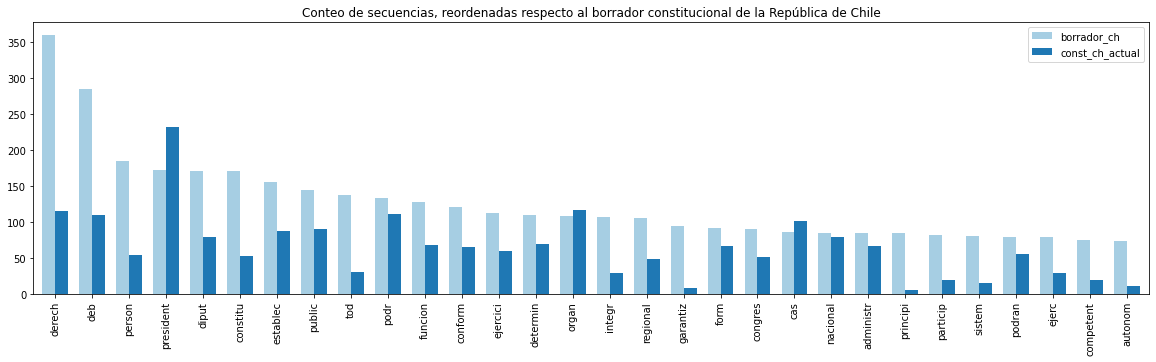

In [ ]:
plot_chile_df = count_vectors_df[["borrador_ch","const_ch_actual"]].sort_values(by="borrador_ch", ascending=False).head(30)
plot_chile_df.plot(kind="bar", figsize=figsize, width=barwidth, color=colors);
plt.title("Conteo de secuencias, reordenadas respecto al borrador constitucional de la República de Chile");

In [ ]:
plot_chile_df[["borrador_ch", "const_ch_actual"]].sort_values(by="borrador_ch", ascending=False).head()

,borrador_ch,const_ch_actual
derech,359,115
deb,284,109
person,185,54
president,172,231
diput,171,79


Respecto a a la distribución de secuencias en el texto vigente, Estos se presentan en relación a su frecuencia en el texto borrador. Se observa una notable diferencia en la frecuencia de la secuencia "constitucional" en ambos documentos con 382 menciones en la constitución vigente, frente a 46 veces en el texto borrador.

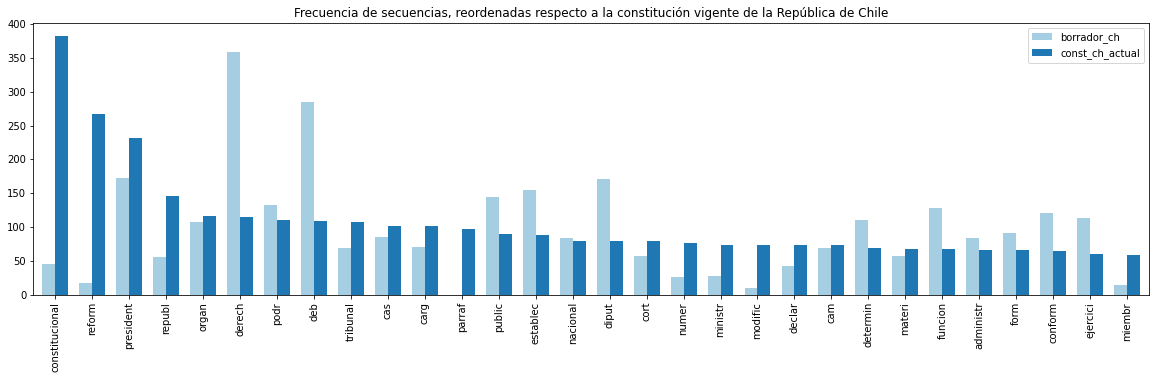

In [ ]:
plot_chile_df = count_vectors_df[["borrador_ch","const_ch_actual"]].sort_values(by="const_ch_actual", ascending=False).head(30)
plot_chile_df.plot(kind="bar", figsize=figsize, width=barwidth, color=colors);
plt.title("Frecuencia de secuencias, reordenadas respecto a la constitución vigente de la República de Chile");

In [ ]:
plot_chile_df[["borrador_ch", "const_ch_actual"]].sort_values(by="const_ch_actual", ascending=False).head()

,borrador_ch,const_ch_actual
constitucional,46,382
reform,17,267
president,172,231
republ,56,146
organ,108,116


### 4.2 Histogramas de puntajes Tf-Idf

Luego de haber revisado los histogramas de conteo de secuencias en los textos en cuestión, realizamos el mismo análisis para las similitudes entre vectores tfidf. Así, el puntaje de frecuencia-relevancia se visualizan respecto a los demás textos.

#### 4.2.1. Borrador constitucional, República de Chile

<br>

A continuación el histograma llamado "Puntaje tf-idf de secuencias del borrador constitucional de la Repúbica de Chile, en orden descendente" muestra que el texto borrador otorga más valor a la secuencia "derech" con 0.37, seguida por "deb" con 0.29. El peak más alto obtenido que no corresponde al texto borrador se observó en la secuencia "president", con ~0.27 en la constitución vigente de la República de Chile, seguido cercanamente por la secuencia "public", siendo más valorada por el texto de la República del Perú.

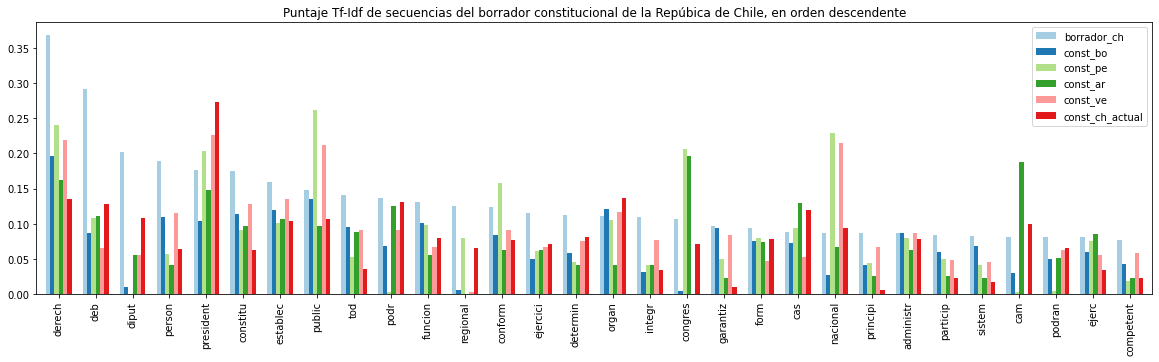

In [ ]:
plot_df_borrador = tfidf_vectors_df.sort_values(by="borrador_ch",ascending=False).head(30)
plot_df_borrador.plot(kind="bar", figsize=figsize, width=barwidth, color=colors);
plt.title("Puntaje Tf-Idf de secuencias del borrador constitucional de la Repúbica de Chile, en orden descendente");

In [ ]:
plot_df_borrador[["borrador_ch"]].rename(columns={"borrador_ch":"Tf-Idf score"}).head()

,Tf-Idf score
derech,0.368018
deb,0.291134
diput,0.202317
person,0.189647
president,0.176320


#### 4.2.2 Constitución vigente de la República de Chile

Los resultados de la figura "Puntaje Tf-Idf de secuencias de la constitución vigente de la República de Chile, en orden descendente" muestra que el puntaje de frecuencia-relevancia de las secuencias fue más alto para la secuencia "constitucional" con 0.45, segudio por "reform" con 0.31. Los cinco mayores puntajes se observan a continuación del gráfico.

En cuanto a la distribución de secuencias, dentro de esta muestra, el peak más alto que se observa de otro texto constitucional, es en la secuencia "derech", seguido por "deb" en el texto borrador de la República de Chile. En cuanto a la secuencia "reform", su puntaje es significativamente más alto que en los textos relacionados, con un puntaje cercano a 0.3, vs un máximo no superior a 0.05.

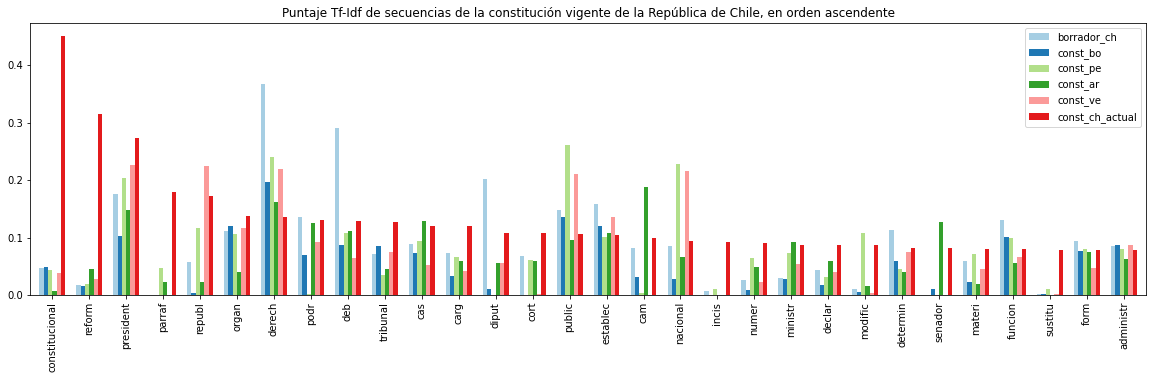

In [ ]:
plot_df_actual = tfidf_vectors_df.sort_values(by="const_ch_actual", ascending=False).head(30)
plot_df_actual.plot(kind="bar", figsize=figsize, width=barwidth, color=colors);
plt.title("Puntaje Tf-Idf de secuencias de la constitución vigente de la República de Chile, en orden ascendente");

In [ ]:
plot_df_actual[["const_ch_actual"]].rename(columns={"const_ch_actual":"Tf-Idf score"}).head()

,Tf-Idf score
constitucional,0.451117
reform,0.315309
president,0.272796
parraf,0.178655
republ,0.172416


#### 4.2.3. Comparación entre borrador y constitución vigente de la República de Chile

Nuevamente visualizamos ambas constituciones desde la perspectiva de los puntajes tfidf obtenidos. Podemos observar diferencias notorias entre el borrador constitucional, completamente nuevo y libre de reformas.

Respecto a la constitución vigente, se aprecia una diferencia en las relevancias de las secuencias, principalmente las ya mencionadas "constitucional" y "reform", las cuales hacen sentido, teniendo en cuenta todas las reformas constitucionales que han habido desde su promulgación, el 1980.

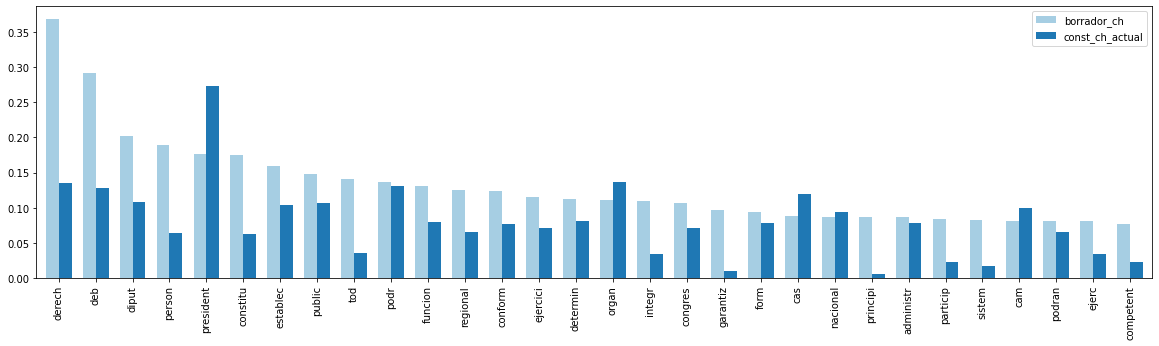

In [ ]:
plot_chile_df = tfidf_vectors_df[["borrador_ch","const_ch_actual"]].sort_values(by="borrador_ch", ascending=False).head(30)
plot_chile_df.plot(kind="bar", figsize=figsize, width=barwidth, color=colors);

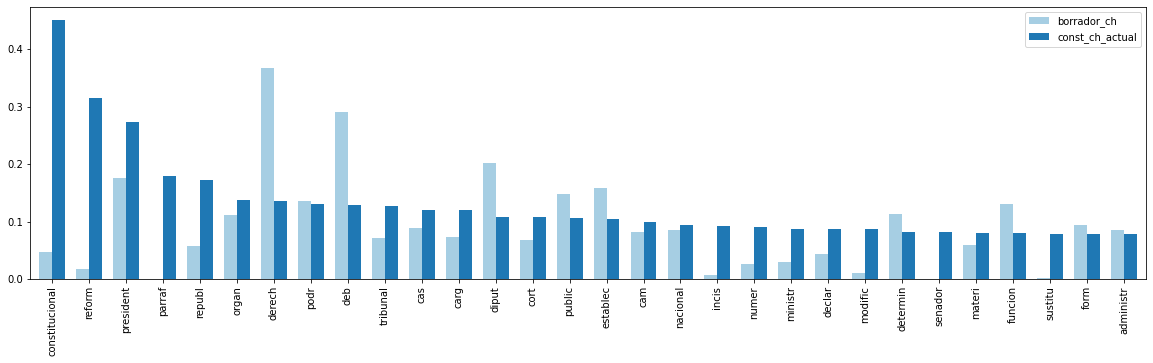

In [ ]:
plot_chile_df = tfidf_vectors_df[["borrador_ch","const_ch_actual"]].sort_values(by="const_ch_actual", ascending=False).head(30)
plot_chile_df.plot(kind="bar", figsize=figsize, width=barwidth, color=colors);

In [ ]:
plot_chile_df[["borrador_ch", "const_ch_actual"]].sort_values(by="const_ch_actual", ascending=False).head()

,borrador_ch,const_ch_actual
constitucional,0.047155,0.451117
reform,0.017427,0.315309
president,0.176320,0.272796
parraf,0.000000,0.178655
republ,0.057407,0.172416


### 4.3 Similitudes entre textos constitucionales

Los resultados a continuación muestra la similitud del coseno entre los vectores generados. 

#### 4.3.1.Similitud entre vectores de conteo, o `CountVectorizer()`

Los resultados a continuación muestra la similitud del coseno entre los vectores generados. El mayor grado de similitud se observa entre los textos de la República Bolivariana de Venezuela con 0.78, seguido por la similitud entre los textos del último mencionado y de la constitución de la República del Perú, con 0.76. La relación más disímil se dió entre los textos de la República de Chile (vigente) 

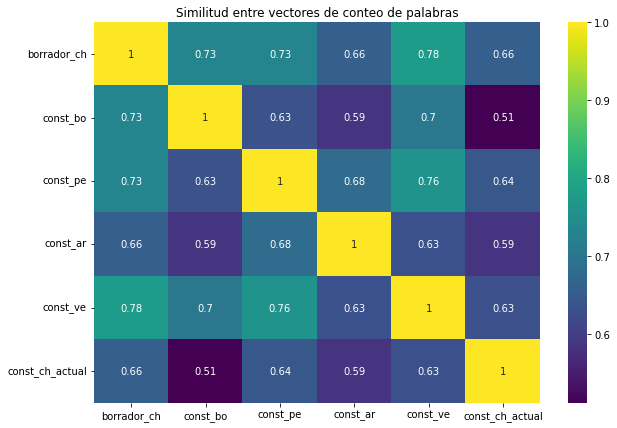

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))         # Sample figsize in inches
sns.heatmap(countvec_cos_df, annot=True, cmap="viridis");
plt.yticks(rotation=0);
plt.title("Similitud entre vectores de conteo de palabras");

Si además quisiéramos tener una métrica de cuán similar es cada texto frente a sus pares, podemos visualizarlo de la siguiente manera:

In [ ]:
countvec_cos_df.sum().sort_values(ascending=False)

borrador_ch        4.561312
const_ve           4.509467
const_pe           4.455909
const_bo           4.172342
const_ar           4.145426
const_ch_actual    4.030755
dtype: float64

Se muestra que el texto borrador de la República de Chile presenta un mayor grado de similitud entre sus pares, seguido por el texto de la República Bolivariana de Venezuela. Por el contrario, el texto más diferente entre sus pares es el texto constitucional vigente de la República de Chile.

#### 4.3.2. Similitud de vectores Tfidf


</br>

En la figura que se muestra a continuación, "Similitud entre vectores tf-idf" se observa que los textos constitucionales más similares son el texto borrador de Chile y la constitución de la República del Perú, con 0.71. A éste le sigue la constitución de la Repùblica Bolivariana de Venezuela con 0.69. Por otro lado, los textos mas disímiles son la constitución de la República de Bolivia y la constitución vigente de la Repúbilca de Chile. Cabe mencionar, que respecto a la constitución vigente, el texto más similar es el texto borrador de Chile, con un 0.62. Se observa que las constituciones que más se distancian de sus pares son la constitución de la República de Bolivia y la constitución vigente de la República de Chile.

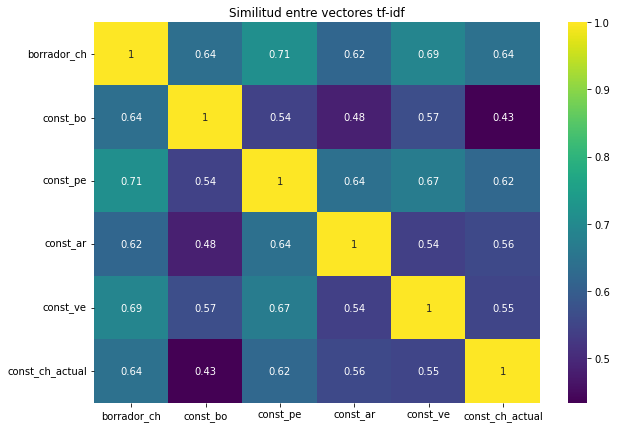

In [ ]:
fig, ax = plt.subplots(figsize=(10,7));
sns.heatmap(tfidf_cos_df, annot=True, cmap="viridis");
plt.yticks(rotation=0);
plt.title("Similitud entre vectores tf-idf");

Naturalmente, observaremos más detalles acerca de los resultados de este vectorizador, para responder a la pregunta ¿Cómo se distribuye la frecuencia-relevancia de las secuencias entre documentos?

In [ ]:
tfidf_cos_df.sum().sort_values(ascending=False)

borrador_ch        4.302017
const_pe           4.188538
const_ve           4.016412
const_ar           3.840108
const_ch_actual    3.808256
const_bo           3.664453
dtype: float64

De la misma manera que anteriormente, podemos observar el grado de similitud que tienen los textos constitucionales entre sus pares, ahora considerando además la relevancia que tienen las secuencias cada documento. El texto borrador de Chile, nuevamente presenta un mayor puntaje en su grado de similitud entre vectores tfidf. 

## 5. Conclusión

Se demostró en este documento, cómo se pueden utilizar técnicas de análisis de textos para, valga la redundancia, analizar textos constitucionales. 

En nuestro análisis, encontramos que respecto al conteo o frecuencia de palabras:

* La mayor similitud fue entre el texto borrador de la República de Chile, y la constitucion de la República Bolivariana de Venezuela, con 0.78. 

* La mayor diferencia se encontró entre los textos de Chile (vigente) y Bolivia, con 0.51. 

* No obstante trabajamos en un dominio donde podemos realizar comparaciones, se observo bastante heterogeneidad entre las palabras utilizadas en cada texto

* Teniendo en cuenta el preprocesamiento, el texto borrador constitucional de la República de Chile resultó ser el más extenso, con 16.733 palabras, seguido por el texto de la República de Bolivia con 14.189 palabras. El texto más corto, resultó ser la constitución vigente de la República de Chile, precedido por el texto de la República bolivariana de Venezuela. 

* El borrador constitucional de Chile resulto ser el más símil considerando los demás textos 

Por el lado de los vectores tfidf, se encontró que:

* El mayor grado de similitud se encontró entre la constitución vigente de la República de Chile y el texto de la República del Peru, con 0.71. 

* La mayor diferencia se observó entre la constitución vigente de la República de Chile y el texto de la República de Bolivia. 

* No obstante se observaron diferencias entre los vectores de conteo y los vectores tfidf, se observaron cambios del ranking de secuencias, agregando una perspectiva más rica en el análisis. 

* En consecuencia del punto anterior, el texto más simil entre sus pares resultó ser el texto borrador de la República de Chile, seguido por el texto de la República del Perú. En el lado contrario, el texto más diferente a todos resultó ser el texto de la República de Bolivia, precedido por el texto vigente de la República de Chile. 


